In [83]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from torch.utils.data import random_split

In [4]:
base_dir = "Images"

In [5]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Root directory contains all subdirectories (e.g., 'good', 'crack', etc.)
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through subdirectories
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                # If the subdirectory is 'good', label as 0 (non-anomalous), else label as 1
                label = 0 if subdir == 'good' else 1
                for image_name in os.listdir(subdir_path):
                    image_path = os.path.join(subdir_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [104]:
class Autoencoder(nn.Module):
    def __init__(self, dropout=0.1):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 32 -> 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 64 -> 128
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),     # 128 -> 256
            nn.Sigmoid(),  # Output in [0, 1]
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [105]:
# Prepare the data
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.ToTensor(), # Normalize to [0, 1]
])

In [106]:
def reconstruction_errors(reconstructed, images):    
    # Compute the reconstruction error (e.g., Mean Squared Error)
    error = (images - reconstructed).pow(2).mean(dim=(1, 2, 3))  # Mean over height, width, channels    
    return error

In [107]:
def train_autoencoder(autoencoder, dataloader, val_dataloader, item, num_epochs, device, optimizer, criterion, scheduler, save_path="."):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Move the model to the specified device
    autoencoder.to(device)
    
    best_val_loss = float('inf')
    all_training_loss = []
    all_validation_loss = []

    # Training loop
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for images, _ in dataloader:
            images = images.to(device)  # Move data to the same device as the model
            
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)  # Compare reconstructed and original images
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Print epoch summary
        avg_loss = running_loss / len(dataloader)
        all_training_loss.append(avg_loss)

        # Switch for validation set
        autoencoder.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, _ in val_dataloader:
                images = images.to(device)

                reconstructed = autoencoder(images)
                val_loss += criterion(reconstructed, images).item()  # Compare reconstructed and original images

        avg_val_loss = val_loss / len(val_dataloader)
        all_validation_loss.append(avg_val_loss)
        
        # Visualize original image vs the same image passed through the autoencoder
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            autoencoder.eval()  # Set model to eval mode for visualization
            with torch.no_grad():
                sample_images, _ = next(iter(dataloader))  # Take a batch from the dataloader
                sample_images = sample_images.to(device)
                reconstructed = autoencoder(sample_images)

                # Plot original and reconstructed images
                fig, ax = plt.subplots(1, 2, figsize=(8, 6))
                ax[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
                ax[0].set_title('Original Image')
                ax[0].axis('off')
                ax[1].imshow(reconstructed[0].cpu().squeeze(), cmap='gray')
                ax[1].set_title('Reconstructed Image')
                ax[1].axis('off')
                plt.show()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train MSE Loss: {avg_loss:.6f}, Val MSE Loss: {avg_val_loss:.6f}")

        # Save the model if validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_filename = f"{item}_autoencoder.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(autoencoder.state_dict(), model_path)
            print(f"New best model saved with MSE loss: {avg_val_loss:.6f}")  

        # Step the learning rate scheduler
        scheduler.step(avg_val_loss)
    
    return model_path, all_training_loss, all_validation_loss

In [108]:
def test_autoencoder(model, best_model_path, test_loader, device):
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.eval()  # Set the model to evaluation mode

    all_errors = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Run images through autoencoder
            reconstructed = model(images)

            # Computer per-sample MSE
            reconstruction_error = torch.mean((reconstructed - images) ** 2, dim=[1,2,3])
            all_errors.extend(reconstruction_error.cpu().numpy())

            # Label 0 is normal, others are anomalous
            binary_labels = (labels != 0).int()
            all_labels.extend(binary_labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_errors)
    pr_auc = auc(recall, precision)

    # Compute F1 scores at each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    # Plot Precision-Recall curve
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve')
    plt.scatter(recall[best_index], precision[best_index], color='red', label='Best F1 Point')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Use best threshold to calculate final classification metrics
    predicted_anomalies = (all_errors > best_threshold).astype(int)

    tp = ((predicted_anomalies == 1) & (all_labels == 1)).sum()
    tn = ((predicted_anomalies == 0) & (all_labels == 0)).sum()
    fp = ((predicted_anomalies == 1) & (all_labels == 0)).sum()
    fn = ((predicted_anomalies == 0) & (all_labels == 1)).sum()

    precision_score = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_score = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score_final = 2 * (precision_score * recall_score) / (precision_score + recall_score + 1e-8)
    accuracy = (tp + tn) / len(all_labels)

    print(f"\n--- Final Metrics at Best Threshold ---")
    print(f"Best Threshold: {best_threshold:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1_score_final:.4f}")
    print(f"AUC: {pr_auc:.4f}")

    return best_threshold, f1_score_final, pr_auc

In [109]:
# Will use the images in the "train/good" directory to establish a baseline of features for defect-free images.
item = "capsule"

# Iterate through the directories of images
item_path = os.path.join(base_dir, item)
train_path = os.path.join(item_path, 'train')
test_path = os.path.join(item_path, 'test')

# Need to split train directory images into train and validation
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_ratio = 0.2 # 20% left for validation
train_size = int((1 - val_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

In [121]:
# Initialize model and hyperparameters
learning_rate = 0.001
weight_decay = 0.001
batch_size = 8
dropout = 0.1
criterion = nn.MSELoss()
model = Autoencoder(dropout=dropout)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, min_lr=1e-6, verbose=True)
epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [122]:
# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Processing: capsule


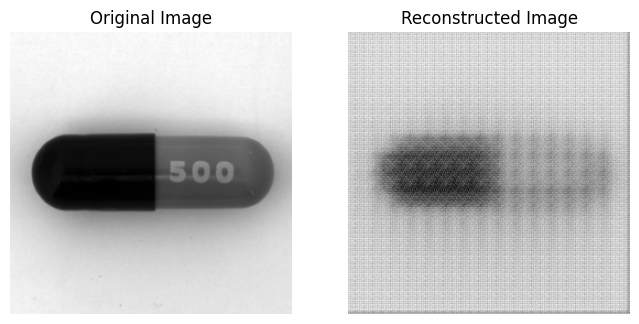

Epoch [1/150], Train MSE Loss: 0.022350, Val MSE Loss: 0.030699
New best model saved with MSE loss: 0.030699
Epoch [2/150], Train MSE Loss: 0.002970, Val MSE Loss: 0.004152
New best model saved with MSE loss: 0.004152
Epoch [3/150], Train MSE Loss: 0.001862, Val MSE Loss: 0.001515
New best model saved with MSE loss: 0.001515
Epoch [4/150], Train MSE Loss: 0.001537, Val MSE Loss: 0.001175
New best model saved with MSE loss: 0.001175
Epoch [5/150], Train MSE Loss: 0.001376, Val MSE Loss: 0.001219
Epoch [6/150], Train MSE Loss: 0.001236, Val MSE Loss: 0.001012
New best model saved with MSE loss: 0.001012
Epoch [7/150], Train MSE Loss: 0.001117, Val MSE Loss: 0.000813
New best model saved with MSE loss: 0.000813
Epoch [8/150], Train MSE Loss: 0.000967, Val MSE Loss: 0.000754
New best model saved with MSE loss: 0.000754
Epoch [9/150], Train MSE Loss: 0.000885, Val MSE Loss: 0.000666
New best model saved with MSE loss: 0.000666
Epoch [10/150], Train MSE Loss: 0.000825, Val MSE Loss: 0.000720

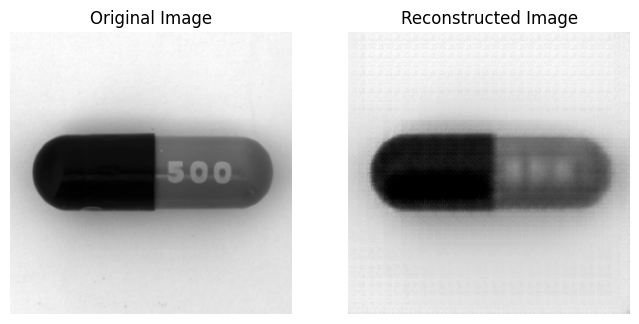

Epoch [11/150], Train MSE Loss: 0.000906, Val MSE Loss: 0.000839
Epoch [12/150], Train MSE Loss: 0.000758, Val MSE Loss: 0.000599
New best model saved with MSE loss: 0.000599
Epoch [13/150], Train MSE Loss: 0.000715, Val MSE Loss: 0.000672
Epoch [14/150], Train MSE Loss: 0.000663, Val MSE Loss: 0.000522
New best model saved with MSE loss: 0.000522
Epoch [15/150], Train MSE Loss: 0.000620, Val MSE Loss: 0.000464
New best model saved with MSE loss: 0.000464
Epoch [16/150], Train MSE Loss: 0.000611, Val MSE Loss: 0.000617
Epoch [17/150], Train MSE Loss: 0.000576, Val MSE Loss: 0.000427
New best model saved with MSE loss: 0.000427
Epoch [18/150], Train MSE Loss: 0.000580, Val MSE Loss: 0.004858
Epoch [19/150], Train MSE Loss: 0.000744, Val MSE Loss: 0.001087
Epoch [20/150], Train MSE Loss: 0.000557, Val MSE Loss: 0.000457


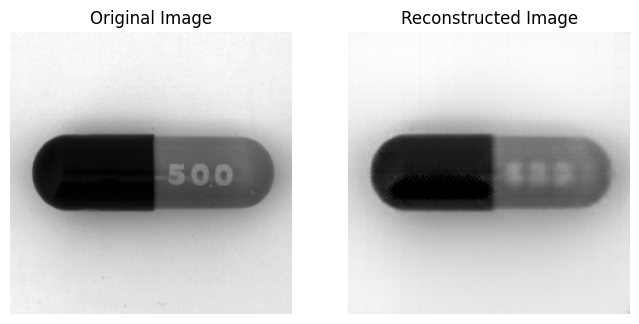

Epoch [21/150], Train MSE Loss: 0.000522, Val MSE Loss: 0.000519
Epoch [22/150], Train MSE Loss: 0.000582, Val MSE Loss: 0.000416
New best model saved with MSE loss: 0.000416
Epoch [23/150], Train MSE Loss: 0.000483, Val MSE Loss: 0.000306
New best model saved with MSE loss: 0.000306
Epoch [24/150], Train MSE Loss: 0.000466, Val MSE Loss: 0.000338
Epoch [25/150], Train MSE Loss: 0.000438, Val MSE Loss: 0.000264
New best model saved with MSE loss: 0.000264
Epoch [26/150], Train MSE Loss: 0.000375, Val MSE Loss: 0.000308
Epoch [27/150], Train MSE Loss: 0.000434, Val MSE Loss: 0.000245
New best model saved with MSE loss: 0.000245
Epoch [28/150], Train MSE Loss: 0.000357, Val MSE Loss: 0.000366
Epoch [29/150], Train MSE Loss: 0.000362, Val MSE Loss: 0.000286
Epoch [30/150], Train MSE Loss: 0.000338, Val MSE Loss: 0.000221
New best model saved with MSE loss: 0.000221


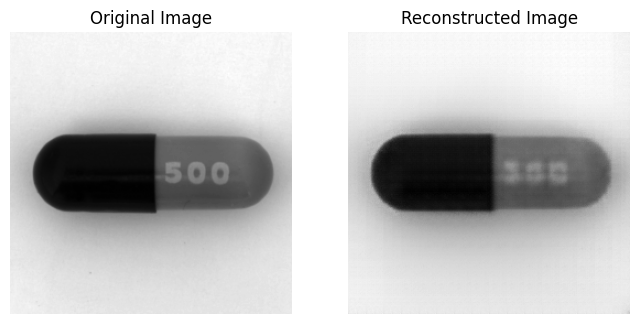

Epoch [31/150], Train MSE Loss: 0.000347, Val MSE Loss: 0.000214
New best model saved with MSE loss: 0.000214
Epoch [32/150], Train MSE Loss: 0.000354, Val MSE Loss: 0.000373
Epoch [33/150], Train MSE Loss: 0.000389, Val MSE Loss: 0.000215
Epoch [34/150], Train MSE Loss: 0.000330, Val MSE Loss: 0.000196
New best model saved with MSE loss: 0.000196
Epoch [35/150], Train MSE Loss: 0.000342, Val MSE Loss: 0.000242
Epoch [36/150], Train MSE Loss: 0.000333, Val MSE Loss: 0.000265
Epoch [37/150], Train MSE Loss: 0.000341, Val MSE Loss: 0.000683
Epoch [38/150], Train MSE Loss: 0.000352, Val MSE Loss: 0.000457
Epoch [39/150], Train MSE Loss: 0.000272, Val MSE Loss: 0.000323
Epoch [40/150], Train MSE Loss: 0.000286, Val MSE Loss: 0.000200


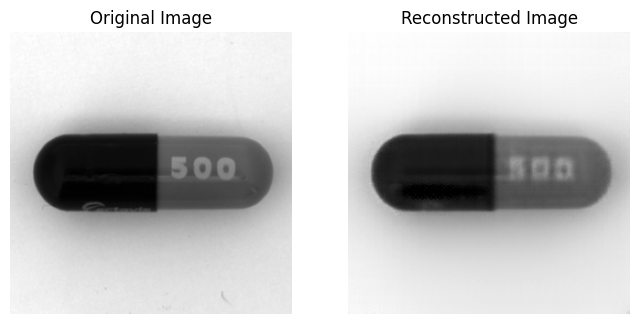

Epoch [41/150], Train MSE Loss: 0.000303, Val MSE Loss: 0.000173
New best model saved with MSE loss: 0.000173
Epoch [42/150], Train MSE Loss: 0.000256, Val MSE Loss: 0.000163
New best model saved with MSE loss: 0.000163
Epoch [43/150], Train MSE Loss: 0.000277, Val MSE Loss: 0.000143
New best model saved with MSE loss: 0.000143
Epoch [44/150], Train MSE Loss: 0.000250, Val MSE Loss: 0.000285
Epoch [45/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000169
Epoch [46/150], Train MSE Loss: 0.000284, Val MSE Loss: 0.000214
Epoch [47/150], Train MSE Loss: 0.000263, Val MSE Loss: 0.000168
Epoch [48/150], Train MSE Loss: 0.000249, Val MSE Loss: 0.000147
Epoch [49/150], Train MSE Loss: 0.000243, Val MSE Loss: 0.000227
Epoch [50/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000142
New best model saved with MSE loss: 0.000142


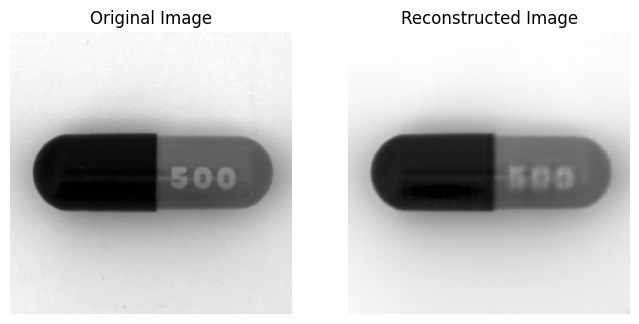

Epoch [51/150], Train MSE Loss: 0.000262, Val MSE Loss: 0.000134
New best model saved with MSE loss: 0.000134
Epoch [52/150], Train MSE Loss: 0.000235, Val MSE Loss: 0.000137
Epoch [53/150], Train MSE Loss: 0.000224, Val MSE Loss: 0.000149
Epoch [54/150], Train MSE Loss: 0.000241, Val MSE Loss: 0.000137
Epoch [55/150], Train MSE Loss: 0.000252, Val MSE Loss: 0.000143
Epoch [56/150], Train MSE Loss: 0.000244, Val MSE Loss: 0.000147
Epoch [57/150], Train MSE Loss: 0.000225, Val MSE Loss: 0.000148
Epoch [58/150], Train MSE Loss: 0.000213, Val MSE Loss: 0.000140
Epoch [59/150], Train MSE Loss: 0.000208, Val MSE Loss: 0.000138
Epoch [60/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000147


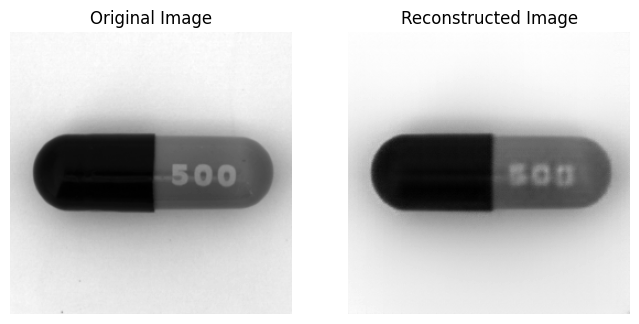

Epoch [61/150], Train MSE Loss: 0.000243, Val MSE Loss: 0.000138
Epoch [62/150], Train MSE Loss: 0.000253, Val MSE Loss: 0.000143
Epoch [63/150], Train MSE Loss: 0.000232, Val MSE Loss: 0.000134
New best model saved with MSE loss: 0.000134
Epoch [64/150], Train MSE Loss: 0.000230, Val MSE Loss: 0.000133
New best model saved with MSE loss: 0.000133
Epoch [65/150], Train MSE Loss: 0.000220, Val MSE Loss: 0.000142
Epoch [66/150], Train MSE Loss: 0.000214, Val MSE Loss: 0.000138
Epoch [67/150], Train MSE Loss: 0.000213, Val MSE Loss: 0.000134
Epoch [68/150], Train MSE Loss: 0.000245, Val MSE Loss: 0.000141
Epoch [69/150], Train MSE Loss: 0.000237, Val MSE Loss: 0.000137
Epoch [70/150], Train MSE Loss: 0.000240, Val MSE Loss: 0.000148


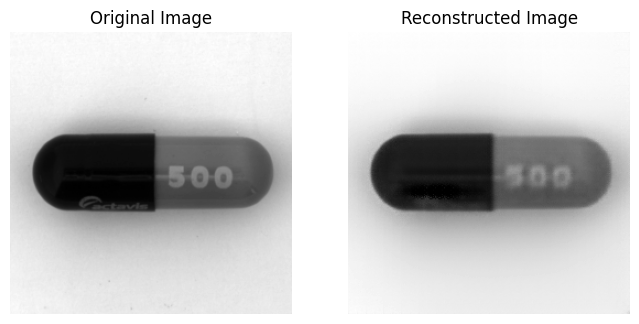

Epoch [71/150], Train MSE Loss: 0.000223, Val MSE Loss: 0.000136
Epoch [72/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000135
Epoch [73/150], Train MSE Loss: 0.000230, Val MSE Loss: 0.000141
Epoch [74/150], Train MSE Loss: 0.000237, Val MSE Loss: 0.000146
Epoch [75/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000134
Epoch [76/150], Train MSE Loss: 0.000251, Val MSE Loss: 0.000144
Epoch [77/150], Train MSE Loss: 0.000221, Val MSE Loss: 0.000139
Epoch [78/150], Train MSE Loss: 0.000233, Val MSE Loss: 0.000152
Epoch [79/150], Train MSE Loss: 0.000214, Val MSE Loss: 0.000138
Epoch [80/150], Train MSE Loss: 0.000208, Val MSE Loss: 0.000139


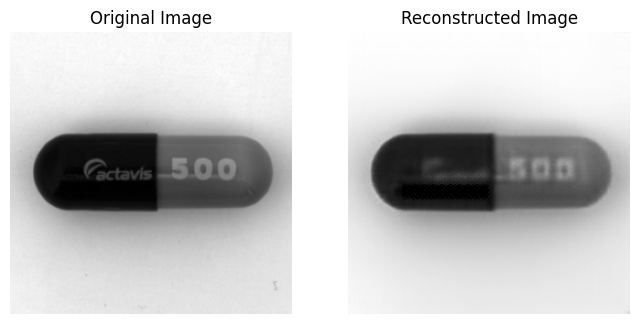

Epoch [81/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000147
Epoch [82/150], Train MSE Loss: 0.000245, Val MSE Loss: 0.000136
Epoch [83/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000144
Epoch [84/150], Train MSE Loss: 0.000235, Val MSE Loss: 0.000134
Epoch [85/150], Train MSE Loss: 0.000230, Val MSE Loss: 0.000133
New best model saved with MSE loss: 0.000133
Epoch [86/150], Train MSE Loss: 0.000246, Val MSE Loss: 0.000136
Epoch [87/150], Train MSE Loss: 0.000222, Val MSE Loss: 0.000138
Epoch [88/150], Train MSE Loss: 0.000210, Val MSE Loss: 0.000149
Epoch [89/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000137
Epoch [90/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000140


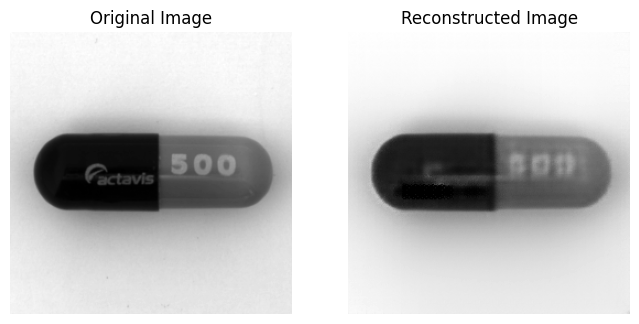

Epoch [91/150], Train MSE Loss: 0.000270, Val MSE Loss: 0.000142
Epoch [92/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000146
Epoch [93/150], Train MSE Loss: 0.000244, Val MSE Loss: 0.000133
Epoch [94/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000136
Epoch [95/150], Train MSE Loss: 0.000221, Val MSE Loss: 0.000140
Epoch [96/150], Train MSE Loss: 0.000219, Val MSE Loss: 0.000136
Epoch [97/150], Train MSE Loss: 0.000225, Val MSE Loss: 0.000157
Epoch [98/150], Train MSE Loss: 0.000214, Val MSE Loss: 0.000140
Epoch [99/150], Train MSE Loss: 0.000219, Val MSE Loss: 0.000139
Epoch [100/150], Train MSE Loss: 0.000255, Val MSE Loss: 0.000147


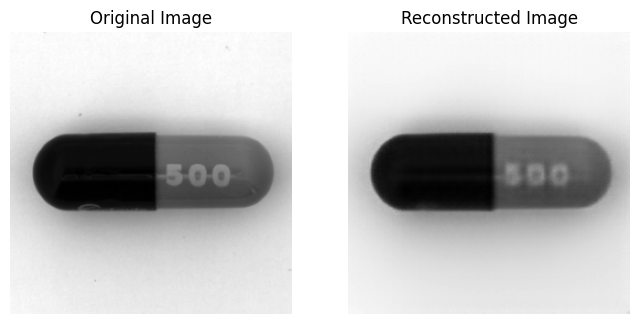

Epoch [101/150], Train MSE Loss: 0.000221, Val MSE Loss: 0.000141
Epoch [102/150], Train MSE Loss: 0.000242, Val MSE Loss: 0.000146
Epoch [103/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000137
Epoch [104/150], Train MSE Loss: 0.000214, Val MSE Loss: 0.000138
Epoch [105/150], Train MSE Loss: 0.000219, Val MSE Loss: 0.000148
Epoch [106/150], Train MSE Loss: 0.000245, Val MSE Loss: 0.000144
Epoch [107/150], Train MSE Loss: 0.000251, Val MSE Loss: 0.000142
Epoch [108/150], Train MSE Loss: 0.000222, Val MSE Loss: 0.000131
New best model saved with MSE loss: 0.000131
Epoch [109/150], Train MSE Loss: 0.000225, Val MSE Loss: 0.000138
Epoch [110/150], Train MSE Loss: 0.000221, Val MSE Loss: 0.000140


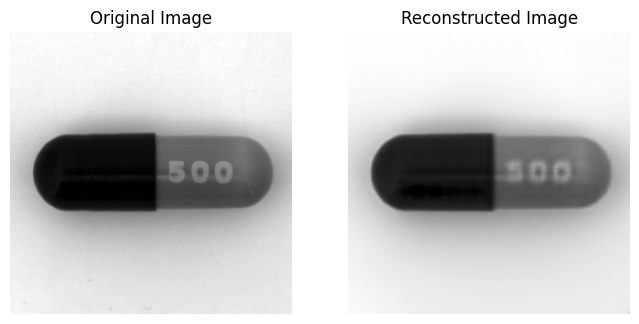

Epoch [111/150], Train MSE Loss: 0.000240, Val MSE Loss: 0.000144
Epoch [112/150], Train MSE Loss: 0.000224, Val MSE Loss: 0.000137
Epoch [113/150], Train MSE Loss: 0.000222, Val MSE Loss: 0.000145
Epoch [114/150], Train MSE Loss: 0.000215, Val MSE Loss: 0.000147
Epoch [115/150], Train MSE Loss: 0.000223, Val MSE Loss: 0.000145
Epoch [116/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000130
New best model saved with MSE loss: 0.000130
Epoch [117/150], Train MSE Loss: 0.000247, Val MSE Loss: 0.000133
Epoch [118/150], Train MSE Loss: 0.000237, Val MSE Loss: 0.000134
Epoch [119/150], Train MSE Loss: 0.000230, Val MSE Loss: 0.000133
Epoch [120/150], Train MSE Loss: 0.000220, Val MSE Loss: 0.000134


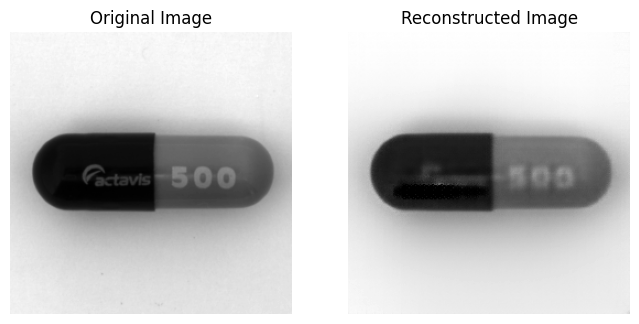

Epoch [121/150], Train MSE Loss: 0.000213, Val MSE Loss: 0.000143
Epoch [122/150], Train MSE Loss: 0.000228, Val MSE Loss: 0.000137
Epoch [123/150], Train MSE Loss: 0.000230, Val MSE Loss: 0.000135
Epoch [124/150], Train MSE Loss: 0.000236, Val MSE Loss: 0.000137
Epoch [125/150], Train MSE Loss: 0.000224, Val MSE Loss: 0.000134
Epoch [126/150], Train MSE Loss: 0.000238, Val MSE Loss: 0.000144
Epoch [127/150], Train MSE Loss: 0.000265, Val MSE Loss: 0.000144
Epoch [128/150], Train MSE Loss: 0.000209, Val MSE Loss: 0.000146
Epoch [129/150], Train MSE Loss: 0.000221, Val MSE Loss: 0.000147
Epoch [130/150], Train MSE Loss: 0.000209, Val MSE Loss: 0.000135


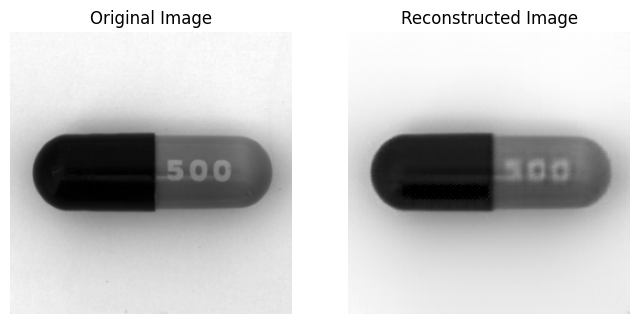

Epoch [131/150], Train MSE Loss: 0.000224, Val MSE Loss: 0.000149
Epoch [132/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000148
Epoch [133/150], Train MSE Loss: 0.000235, Val MSE Loss: 0.000141
Epoch [134/150], Train MSE Loss: 0.000242, Val MSE Loss: 0.000133
Epoch [135/150], Train MSE Loss: 0.000227, Val MSE Loss: 0.000139
Epoch [136/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000135
Epoch [137/150], Train MSE Loss: 0.000234, Val MSE Loss: 0.000134
Epoch [138/150], Train MSE Loss: 0.000225, Val MSE Loss: 0.000135
Epoch [139/150], Train MSE Loss: 0.000235, Val MSE Loss: 0.000131
Epoch [140/150], Train MSE Loss: 0.000238, Val MSE Loss: 0.000137


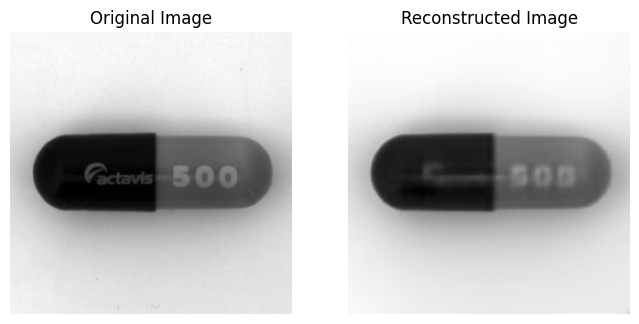

Epoch [141/150], Train MSE Loss: 0.000226, Val MSE Loss: 0.000139
Epoch [142/150], Train MSE Loss: 0.000211, Val MSE Loss: 0.000136
Epoch [143/150], Train MSE Loss: 0.000224, Val MSE Loss: 0.000138
Epoch [144/150], Train MSE Loss: 0.000243, Val MSE Loss: 0.000140
Epoch [145/150], Train MSE Loss: 0.000222, Val MSE Loss: 0.000150
Epoch [146/150], Train MSE Loss: 0.000217, Val MSE Loss: 0.000136
Epoch [147/150], Train MSE Loss: 0.000236, Val MSE Loss: 0.000132
Epoch [148/150], Train MSE Loss: 0.000231, Val MSE Loss: 0.000135
Epoch [149/150], Train MSE Loss: 0.000227, Val MSE Loss: 0.000140


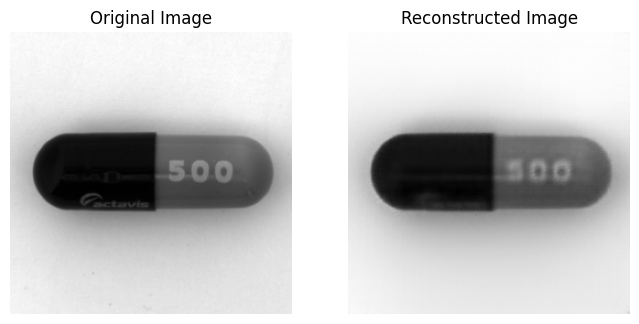

Epoch [150/150], Train MSE Loss: 0.000215, Val MSE Loss: 0.000140


In [123]:
# Begin training
print(f"Processing: {item}")
best_performing_model, train_losses, validation_losses = train_autoencoder(model, train_loader, val_loader, item, epochs, device, optimizer, criterion, scheduler)    

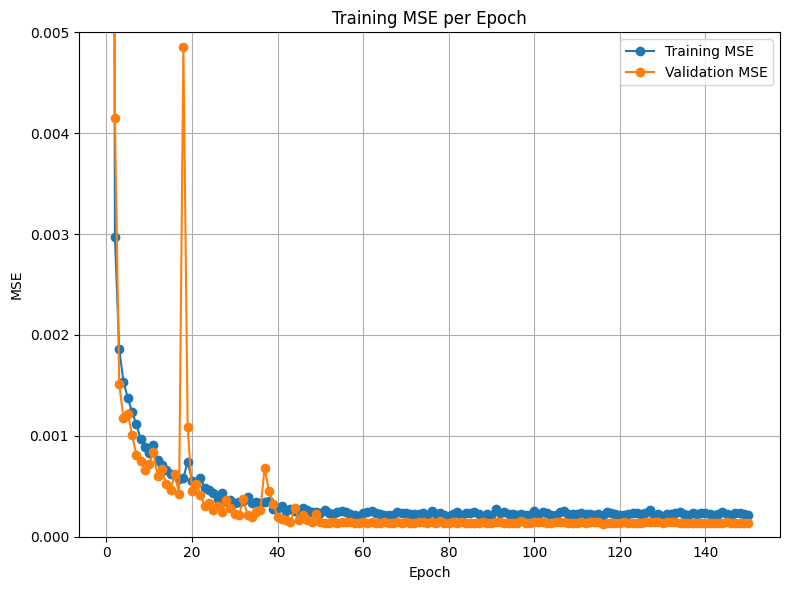

In [124]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training MSE', marker='o')
plt.plot(epochs, validation_losses, label='Validation MSE', marker='o')
plt.title('Training MSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.005)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

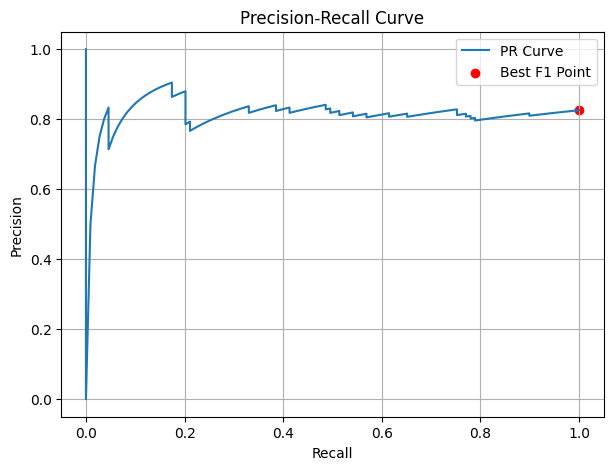


--- Final Metrics at Best Threshold ---
Best Threshold: 0.000064
Accuracy: 0.8182
Precision: 0.8244
Recall: 0.9908
F1 Score: 0.9000
AUC: 0.8119


In [125]:
best_threshold, best_f1, pr_auc = test_autoencoder(model, f"{item}_autoencoder.pth", test_loader, device)